In [53]:
from IPython.display import display, HTML
import os
import time
import pickle
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 300)
%matplotlib inline

def load_data(filename):
    with open(filename, 'rb') as fin:
        return pickle.load(fin)
    
def save_data(obj, filename):
    with open(filename, 'wb+') as fout:
        pickle.dump(obj, fout)

import os
root_path = 'C:/Users/yuanl/Documents/MelbDatathon2017/'

In [11]:
def read_patients(i):
    df = pd.read_csv(root_path + 'Final_summary/patient_%d.csv' % i, usecols=['Patient_ID', 'Drug_ID'])
#                      parse_dates = ['Dispense_Week'],
#                     usecols=['Patient_ID', 'Store_ID', 'Drug_ID', 'Dispense_Week'])
#     df.columns = ['PID', 'SID', 'DID', 'DispWeek']
    df.columns = ['PID', 'DID']
    return df

def convert_to_matrix(df):
    assert(all(dtype in {np.dtype('int64'), np.dtype('<M8[ns]')} 
               for dtype in df.dtypes.values)) # data dtype is either date or int64

    matrix = np.zeros(df.shape, dtype=np.int32)

    year2000 = np.datetime64('2000-01-01')
    for i, (col_dtype, col_name) in enumerate(zip(df.dtypes.values, df.columns)):
        if col_dtype == np.dtype('int64'):
            matrix[:, i] = df[col_name].values
        else:
            matrix[:, i] = (df[col_name].values - year2000).astype('timedelta64[D]')
    return matrix, df.index.values

def read_data(file_range):
    transactions = []
    for i in file_range:
        print(i, end=' ')
        transactions.append(convert_to_matrix(read_patients(i))[0])
    print('finish loading')

    transactions = np.vstack(transactions)

    transactions[:, 0] -= transactions[:, 0].min() # now patient ID starts at 0
    return transactions

In [12]:
%%time
transactions = read_data(range(1, 51)) # 1~50

num_patients = transactions[-1, 0] + 1
print('patients in the training set:', num_patients)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 finish loading
patients in the training set: 558352
Wall time: 27.1 s


In [3]:
drug_lookup = pd.read_csv('drug_with_illness_lookup.csv', encoding='utf-16', sep='\t', index_col='DID')

In [27]:
drug_lookup = drug_lookup.loc[~drug_lookup.L2C.isnull()]
L2C_lookup = drug_lookup[['L2C']].copy()

In [19]:
transactions = transactions[np.in1d(transactions[:, 1], L2C_lookup.index.values)]

In [20]:
unique_DID, encoded_DID = np.unique(transactions[:, 1], return_inverse=True)

In [37]:
transactions[:, 1] = encoded_DID

In [24]:
unique_L2C, encoded_L2C = np.unique(L2C_lookup.L2C.values, return_inverse=True)

In [28]:
L2C_lookup['encoded_L2C'] = encoded_L2C

In [32]:
encoded_L2C_of_unique_DID = L2C_lookup.loc[unique_DID, 'encoded_L2C'].values

In [34]:
num_unique_L2C = unique_L2C.shape[0]

In [35]:
output = np.zeros((num_patients, num_unique_L2C), dtype=np.int32)

In [36]:
patients = np.asanyarray(np.split(transactions, np.bincount(transactions[:, 0]).cumsum()[:-1]))

In [38]:
for i, patient in enumerate(patients):
    output[i, :] = np.bincount(encoded_L2C_of_unique_DID[patient[:, 1]], minlength=num_unique_L2C)

In [50]:
df = pd.DataFrame(output, columns=unique_L2C)

In [43]:
df.to_csv(root_path + 'ATC_L2_count.csv', index_label='PID')

In [47]:
df = pd.DataFrame(output.astype(bool).astype(int), columns=unique_L2C)

In [48]:
df.to_csv(root_path + 'ATC_L2_binary.csv', index_label='PID')

In [75]:
np.argmax(output.astype(bool).sum(axis=1))

372446

In [76]:
output[372446].sum()

962

In [57]:
atc_type_count = output.astype(bool).sum(axis=1)

In [62]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

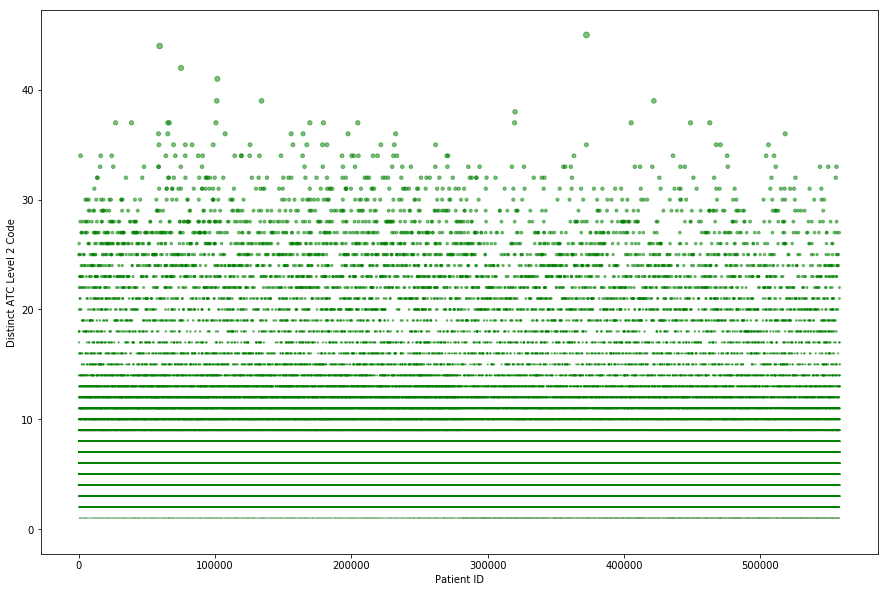

In [72]:
fig, ax = plt.subplots()
plt.scatter(np.arange(num_patients), atc_type_count, c='green',
            marker='o', s=10*(atc_type_count/30)**3, alpha=0.5)
plt.ylabel('Distinct ATC Level 2 Code')
plt.xlabel('Patient ID')
plt.show()
fig.savefig('test.png', bbox_inches='tight')